In [2]:
import pandas as pd
import numpy as np
import scipy as sci
import arch
import pyvinecopulib as pv
import matplotlib.pyplot as plt
import plotly.express as px
from SourceCodes.invariance_analysis import quick_invariance_analysis
from SourceCodes.garch_aux_methods import zero_mean_garch_1_1_scenario


columns_mappings = {'ES1 Index': 'SP500',
                    'NQ1 Index': 'Nasdaq100',
                    'VG1 Index': 'Euro Stox50',
                    'BZ1 Index': 'Ibovespa',
                    'TY1 Comdty':'10-Year Treasury',
                    'RX1 Comdty': 'Euro Bund',
                    'EC1 Curncy': 'EUR/USD',
                    'BP1 Curncy': 'GBP/USD',
                    'UC1 Curncy': 'USD/BRL',
                    'CL1 Comdty': 'WTI',
                    'CO1 Comdty': 'Brent'}

selected_securities = ['SP500', 'Nasdaq100', 'Ibovespa', '10-Year Treasury','USD/BRL']


In [3]:
# Reading data
df = pd.read_csv("Data/data.csv", index_col="Dates", date_parser = pd.to_datetime).rename(columns=columns_mappings)[selected_securities]
df.sort_index(inplace=True)
returns_scale_factor = 100
df_log_ret = np.log(df).diff() * returns_scale_factor
n = df.shape[0]
n_os = 252
n_scenarios = 1000
seeds = [int(x) for x in np.ones(len(selected_securities)).tolist()]

C:\Users\yuriv\.conda\envs\py37\lib\site-packages\matplotlib\cbook\__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
C:\Users\yuriv\.conda\envs\py37\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
C:\Users\yuriv\.conda\envs\py37\lib\site-packages\matplotlib\axes\_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


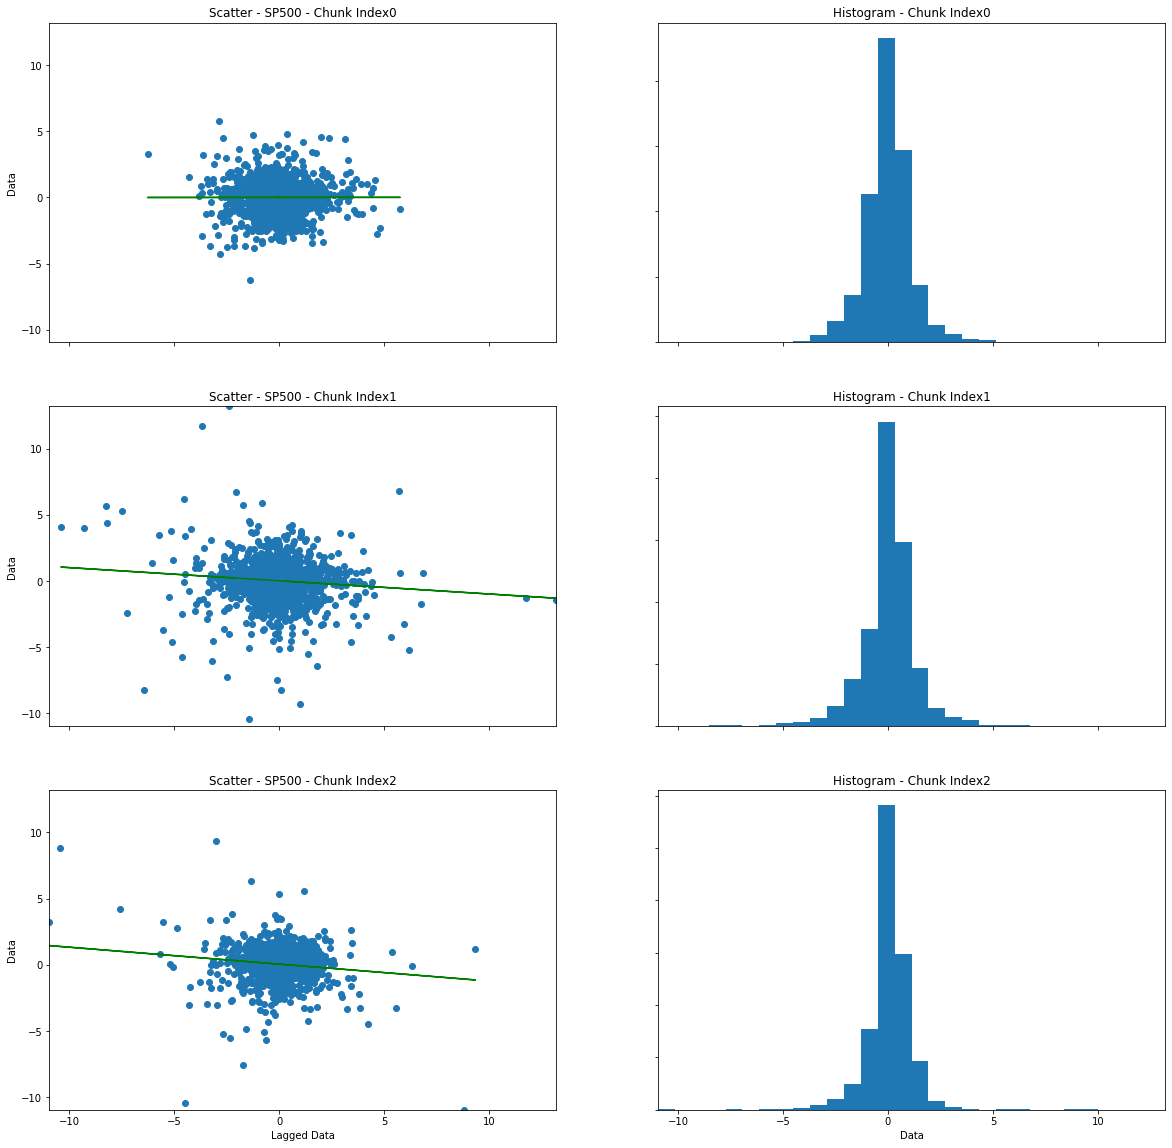

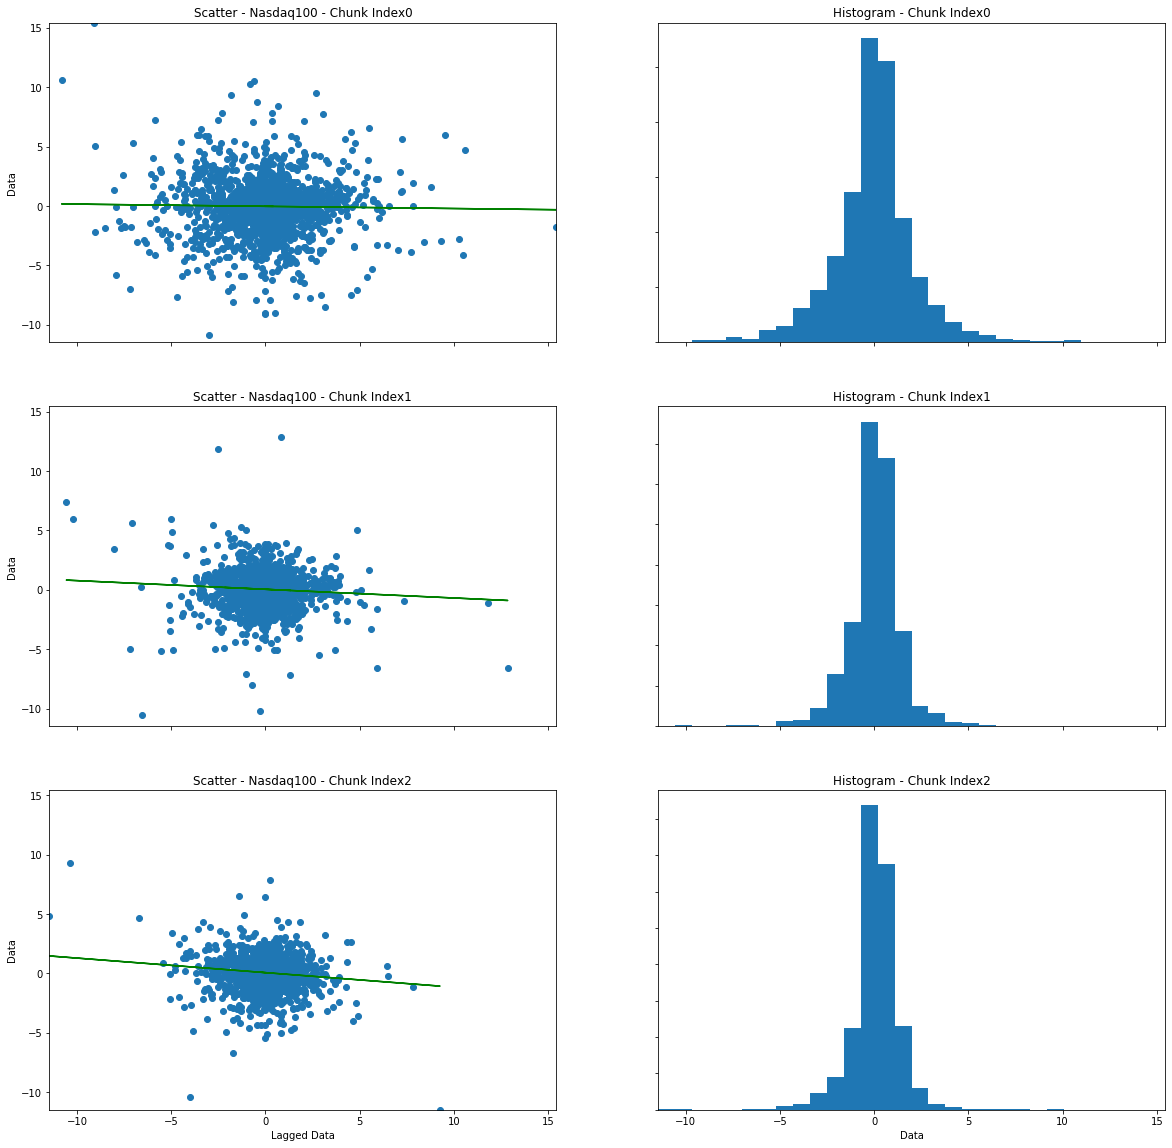

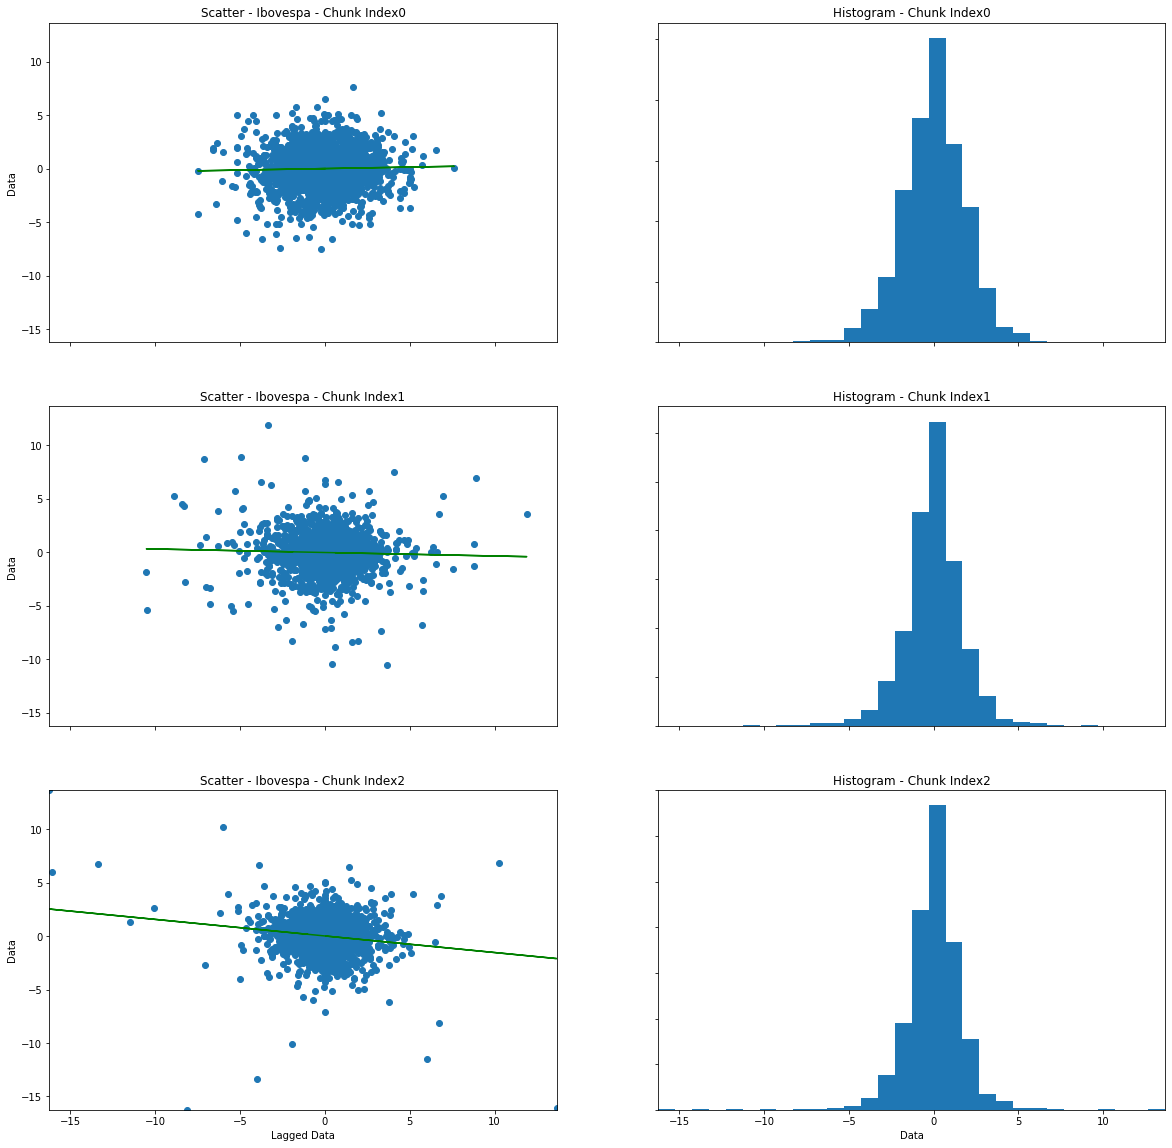

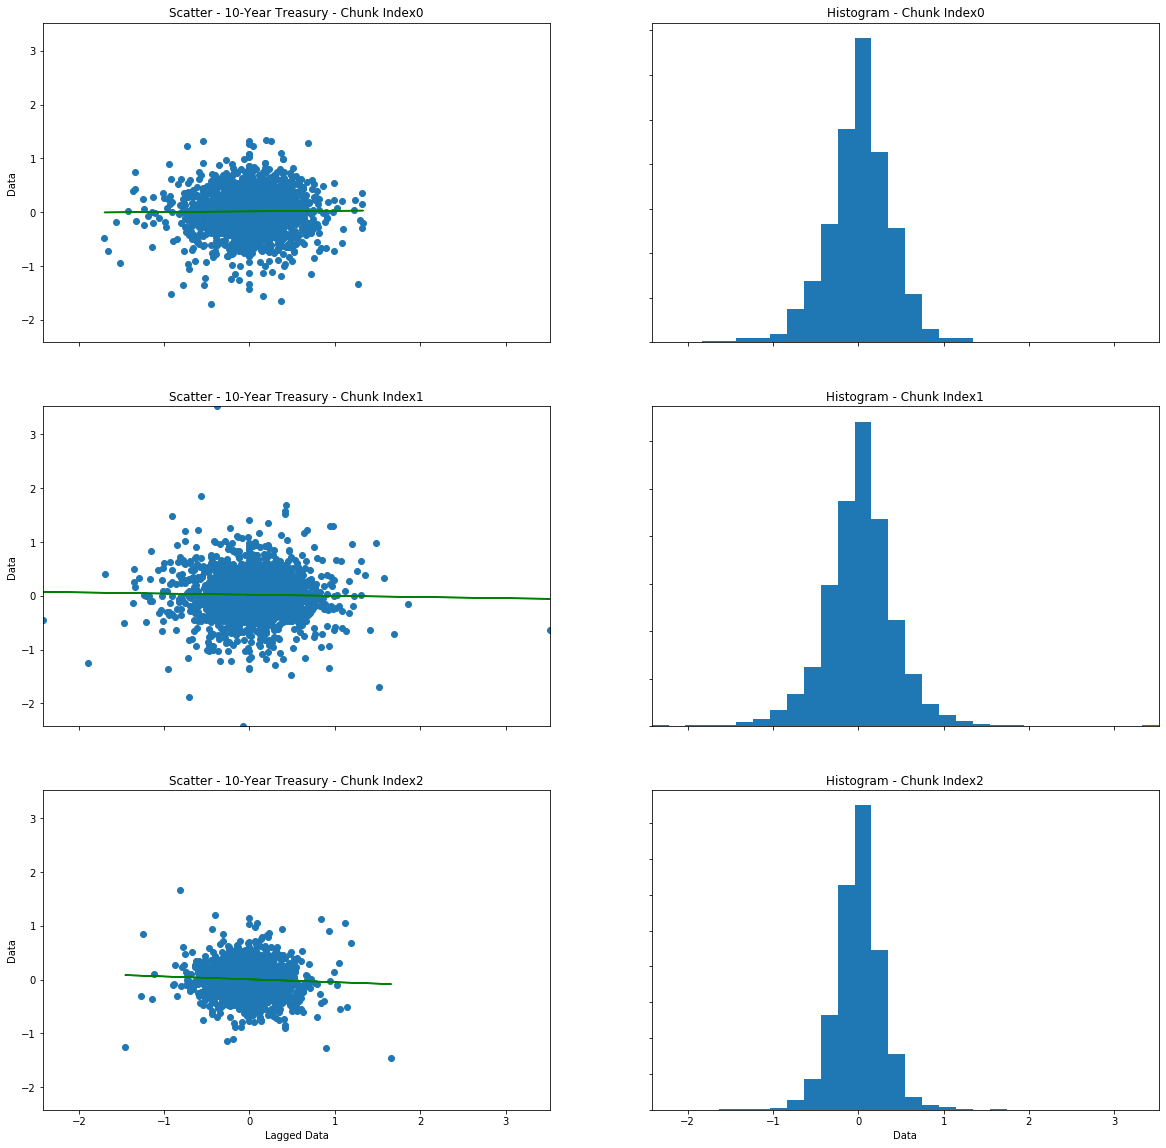

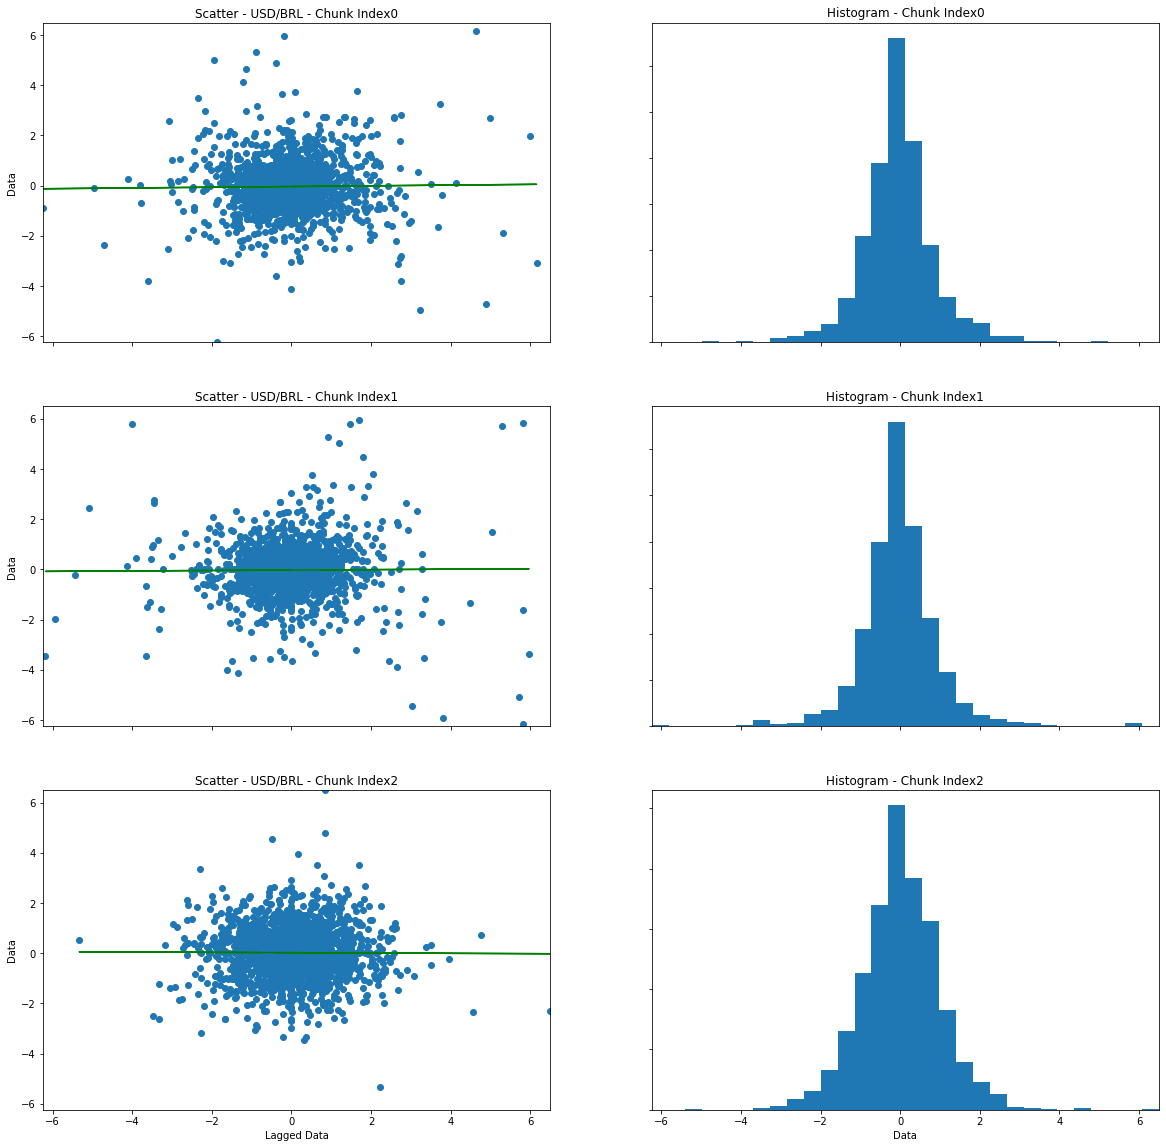

In [4]:
# Quick Invariance Analysis
for item in df_log_ret.columns:
    fig, axs = quick_invariance_analysis(df_log_ret[item].iloc[:-n_os], n_chunks=3, nbins=30)
    fig.set_size_inches(20, 20)

In [5]:
# Fitting a GARCH(1,1) Model and
model_list = []

for k, item in enumerate(df_log_ret):
    mdl = list()
    mdl.append(arch.arch_model(df_log_ret.iloc[1:-n_os, k] , mean="Zero", vol="GARCH", p=1, q=1, dist="normal"))
    mdl[0].constraints()
    mdl.append(mdl[0].fit())
    model_list.append(mdl)

Iteration:      1,   Func. Count:      5,   Neg. LLF: 453823387.4988096
Iteration:      2,   Func. Count:     11,   Neg. LLF: 11357.310371514155
Iteration:      3,   Func. Count:     17,   Neg. LLF: 8229.501650905266
Iteration:      4,   Func. Count:     22,   Neg. LLF: 8053.330765226148
Iteration:      5,   Func. Count:     27,   Neg. LLF: 8313.972701500628
Iteration:      6,   Func. Count:     32,   Neg. LLF: 8039.7356817586915
Iteration:      7,   Func. Count:     36,   Neg. LLF: 8039.719287118261
Iteration:      8,   Func. Count:     40,   Neg. LLF: 8039.715244314894
Iteration:      9,   Func. Count:     44,   Neg. LLF: 8039.715053332276
Iteration:     10,   Func. Count:     48,   Neg. LLF: 8039.715049519571
Iteration:     11,   Func. Count:     51,   Neg. LLF: 8039.715049519022
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8039.715049519571
            Iterations: 11
            Function evaluations: 51
            Gradient evaluations: 

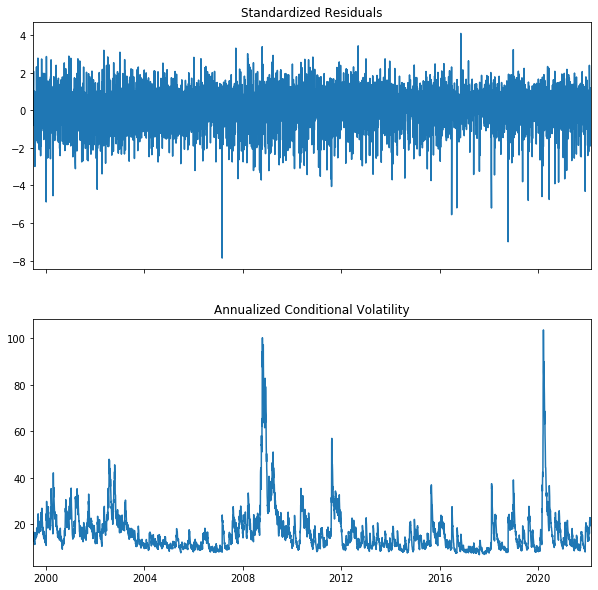

In [31]:
# Example - Univariate Fitting
fig = model_list[0][1].plot(scale=252)
fig.set_size_inches(10, 10)

In [7]:
# Creating the matrix of residuals and scatter plotting
for k, item in enumerate(model_list):
    if k == 0:
        df_log_resid = pd.DataFrame(item[1].std_resid)
        df_log_resid.rename(columns={df_log_resid.columns[-1]:item[0].y.name}, inplace=True)
    else:
        df_log_resid = pd.concat([df_log_resid, pd.DataFrame(item[1].std_resid)], axis=1)
        df_log_resid.rename(columns={df_log_resid.columns[-1]:item[0].y.name}, inplace=True)

C:\Users\yuriv\.conda\envs\py37\lib\site-packages\matplotlib\axes\_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]


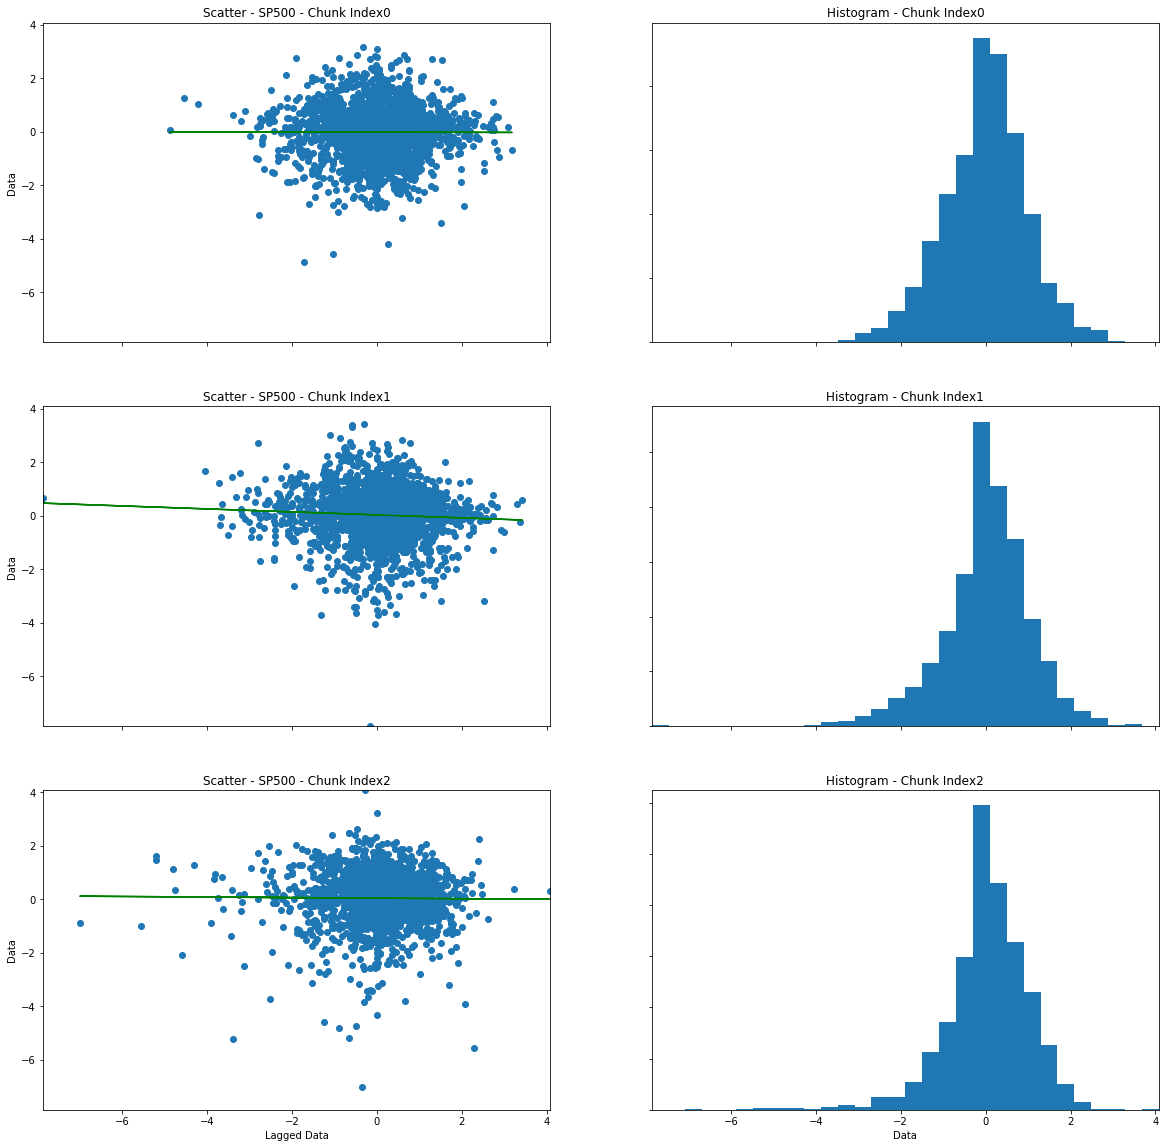

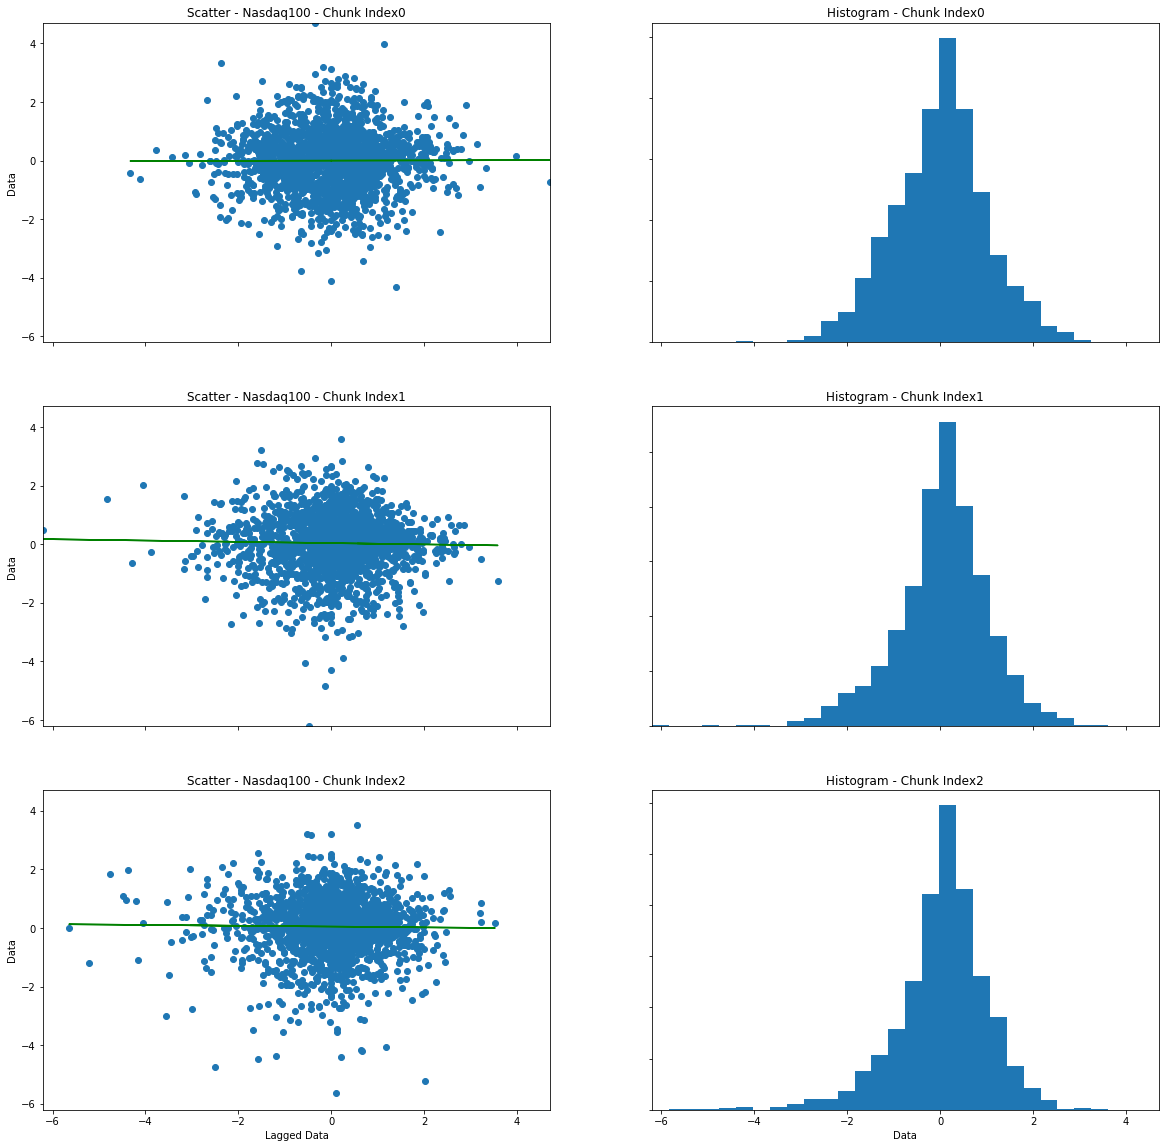

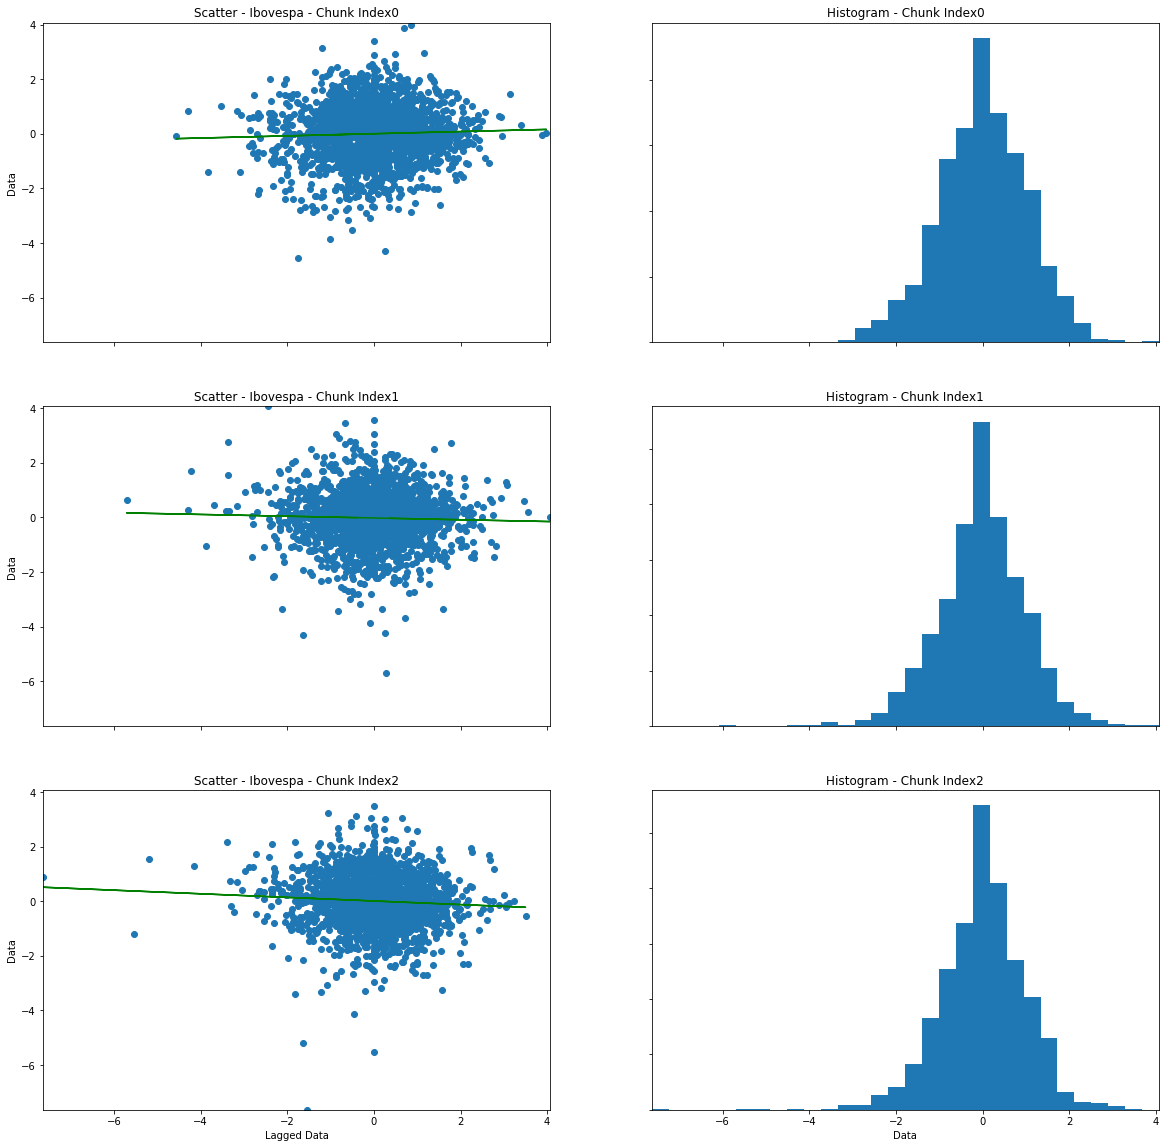

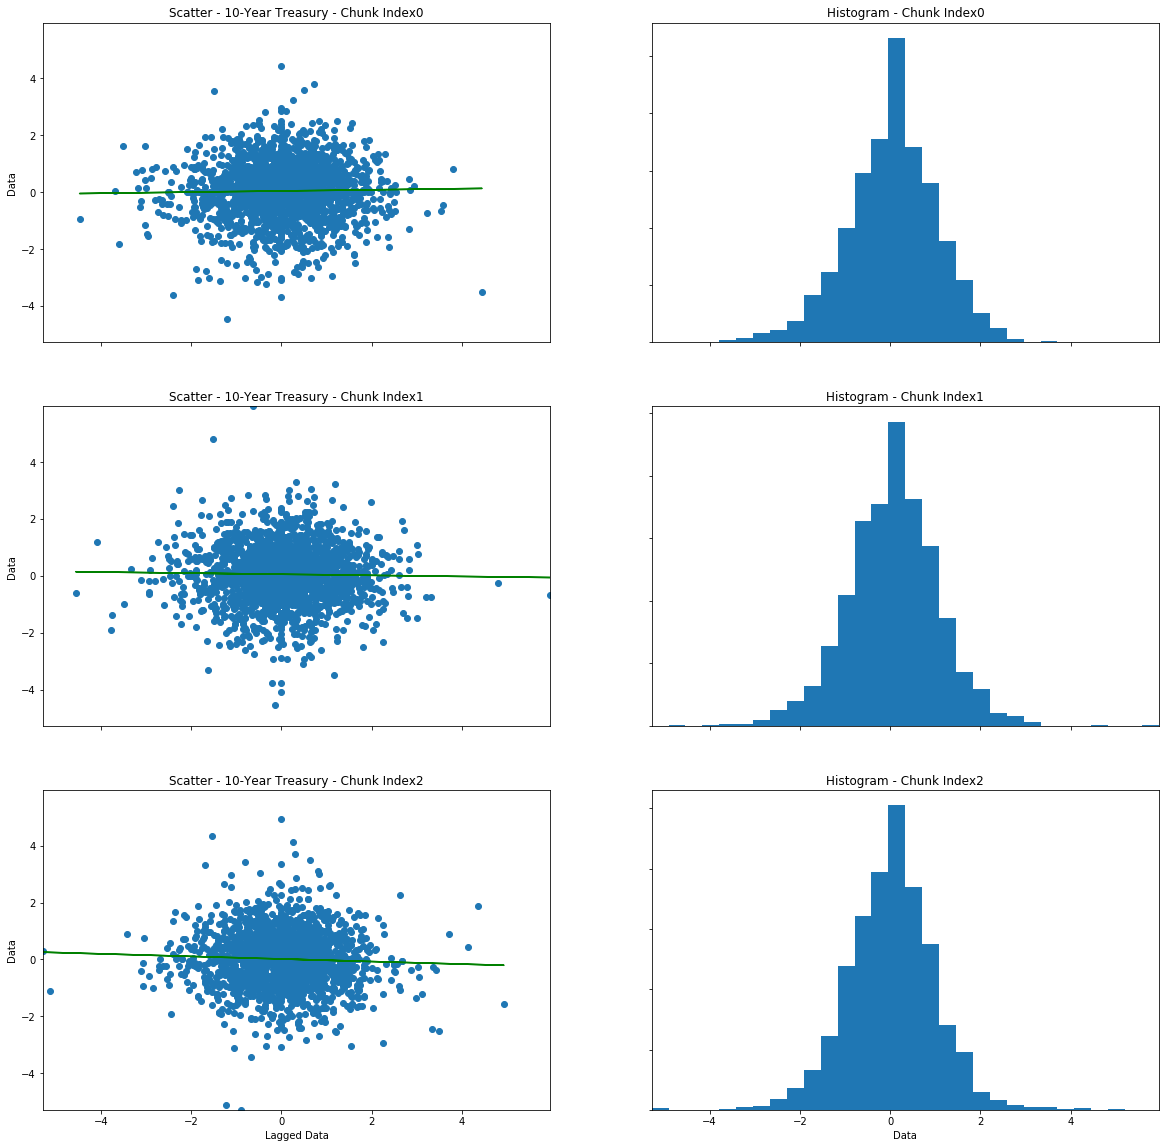

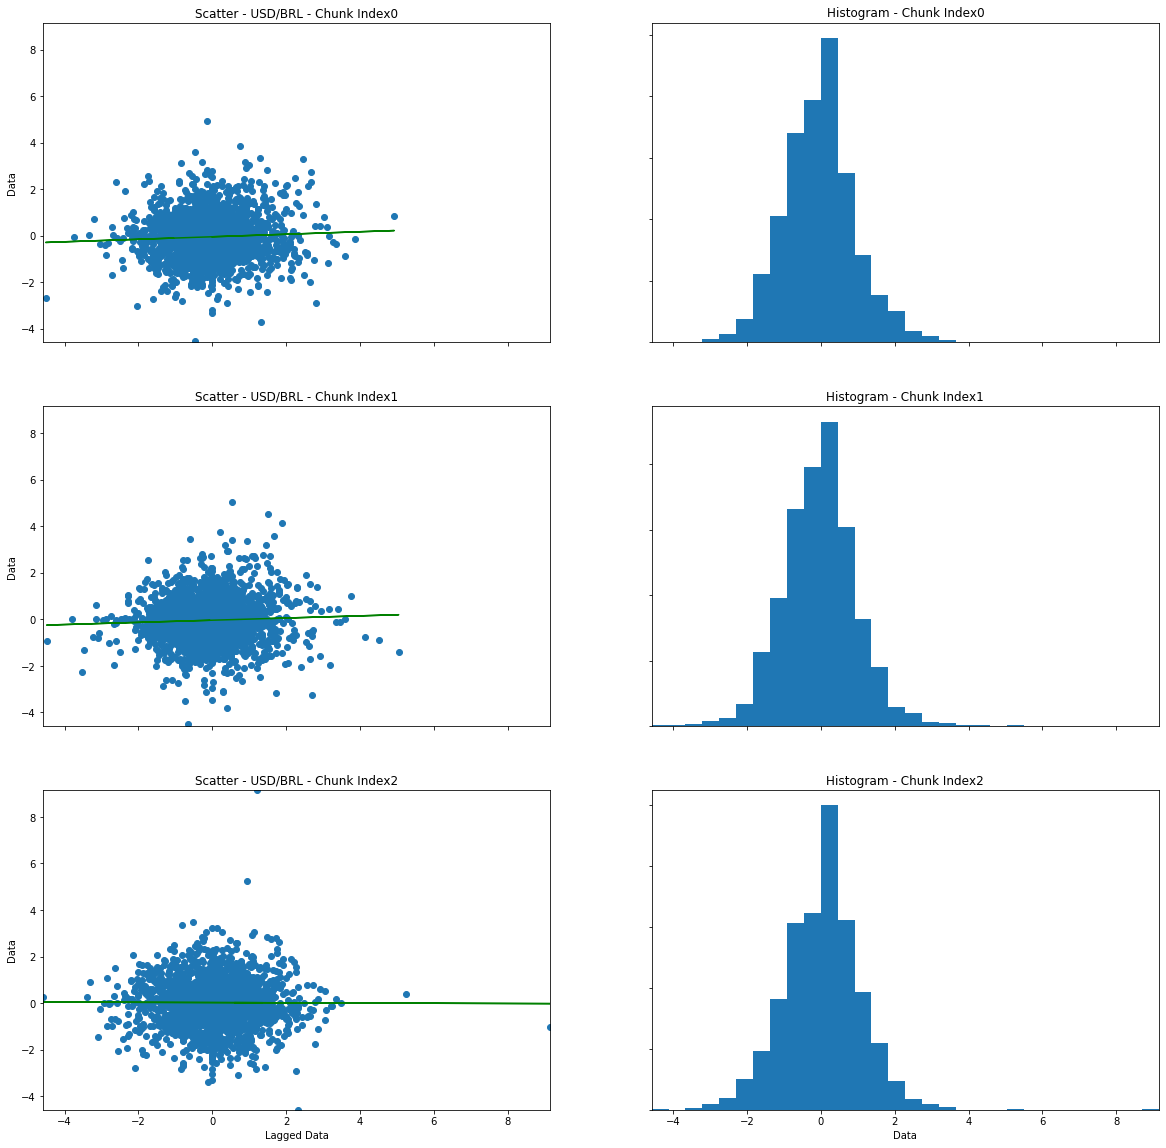

In [8]:
# Quick Invariance Analysis - Of residuals
for item in df_log_resid.columns:
    fig, axs = quick_invariance_analysis(df_log_resid[item], n_chunks=3, nbins=30)
    fig.set_size_inches(20, 20)

In [9]:
# Calculating the pseudo-observations - Estimated Probability Integral Transform
for k, item in enumerate(model_list):
    if k == 0:
        df_log_resid_pseudo_observations = pd.DataFrame(sci.stats.norm.cdf(df_log_resid.iloc[:, k]))
    else:
        df_log_resid_pseudo_observations = pd.concat([df_log_resid_pseudo_observations, pd.Series(sci.stats.norm.cdf(df_log_resid.iloc[:, k]))], axis=1, ignore_index=True)

df_log_resid_pseudo_observations.columns = df_log_resid.columns
df_log_resid_pseudo_observations.columns = df_log_resid.columns
df_log_resid_pseudo_observations.index=df_log_resid.index

In [10]:
# Empirical Copula Plotting
fig1 =  px.scatter_matrix(data_frame=df_log_resid_pseudo_observations,
                          dimensions=df_log_resid_pseudo_observations.columns,
                          height=2000, width=2000)
fig1.update_traces(marker=dict(size=4, line=dict(width=1)), opacity=0.6, showlegend=False)
#fig1.update_traces(diagonal_visible=False)
fig1.update_layout(plot_bgcolor = "#ffebe3", colorway = ["#ff774a"], title = "Empirical Copula")
fig1.update_layout({"yaxis"+str(i+1): dict(range = [0, 1]) for i in range(1, len(df.columns))})
fig1.update_layout({"xaxis"+str(i+1): dict(range = [0, 1]) for i in range(1, len(df.columns))})
fig1.update_xaxes(visible=True, showgrid=True)
fig1.update_yaxes(visible=True, showgrid=True)
fig1.write_html("HTML/file.html")
#fig1.show()

In [ ]:
# Meta Distribution - Distribution which is constructed by an arbitrary copula and arbitrary marginal distributions

In [11]:
# Creating Vine - Structure
copVine = pv.Vinecop(d = df_log_resid_pseudo_observations.columns.shape[0])

# Selecting Most Appropriate Model Given pseudo-observations
copVine.select(data=df_log_resid_pseudo_observations)

In [12]:
print(copVine)

<pyvinecopulib.Vinecop>
** Tree: 0
2,1 <-> Student, parameters = 0.893757
 9.51156
4,1 <-> Student, parameters = -0.295124
  8.62378
1,3 <-> Student, parameters = 0.534157
 13.3647
3,5 <-> Student, parameters = -0.492078
  12.5336
** Tree: 1
2,3 | 1 <-> Student, parameters = 0.0258263
  18.9007
4,3 | 1 <-> Student, parameters = -0.0275507
   39.1932
1,5 | 3 <-> Student, parameters = -0.0794997
   32.1504
** Tree: 2
2,5 | 3,1 <-> Frank, parameters = 0.241336
4,5 | 3,1 <-> Student, parameters = -0.0499529
   39.0712
** Tree: 3
2,4 | 5,3,1 <-> Student, parameters = 0.0160907
  27.4015



In [13]:
# Simulating U - Given Vine - Empirical X Simulated Copulas
n_sim = 10000
u_sim = pd.DataFrame(copVine.simulate(n_sim, seeds=seeds), columns=df_log_resid_pseudo_observations.columns)

In [14]:
# Plotting simulation results given Vine
fig2 =  px.scatter_matrix(data_frame=u_sim,
                          dimensions=u_sim.columns,
                          height=2000, width=2000)
fig2.update_traces(marker=dict(size=4, line=dict(width=1)), opacity=0.6, showlegend=False)
#fig1.update_traces(diagonal_visible=False)
fig2.update_layout(plot_bgcolor = "#ffebe3", colorway = ["#ff774a"], title = "Simulated Data - Given Vine Structure")
fig2.update_layout({"yaxis"+str(i+1): dict(range = [0, 1]) for i in range(1, len(df.columns))})
fig2.update_layout({"xaxis"+str(i+1): dict(range = [0, 1]) for i in range(1, len(df.columns))})
fig2.update_xaxes(visible=True, showgrid=True)
fig2.update_yaxes(visible=True, showgrid=True)
fig2.write_html("HTML/simulated.html")

In [15]:
# Scenario Simulation - Vine Copula
scenarios_copula = list()

for k in range(n_scenarios):
    scenario_copula = dict()
    scenario_copula['u_sim'] = pd.DataFrame(copVine.simulate(n_os), columns=df_log_resid_pseudo_observations.columns)

    sim_given_models_copula = []
    for d, model in enumerate(model_list):
        # Filterting data - Given Models + Simulated Residuals
        sim_given_models_copula.append(zero_mean_garch_1_1_scenario(sci.stats.norm.ppf(scenario_copula['u_sim'].iloc[:, d]), model[1].conditional_volatility,
                                                             model[1].resid, w=model[1].params.omega, alpha=model[1].params['alpha[1]'],
                                                             beta=model[1].params['beta[1]']))
        # Return projection for the proposed horizon
        if d == 0:
            projected_returns_simulation_copula = pd.DataFrame(pd.Series(np.exp(np.cumsum(sim_given_models_copula[d][0] / returns_scale_factor)) - 1))
        else:
            projected_returns_simulation_copula = pd.concat([projected_returns_simulation_copula, pd.Series(np.exp(np.cumsum(sim_given_models_copula[d][0] / returns_scale_factor)) - 1)], axis=1, ignore_index=True)

    projected_returns_simulation_copula.index = df_log_ret.index[-n_os:]
    projected_returns_simulation_copula.columns = selected_securities

    scenario_copula["sim_given_models"] = sim_given_models_copula
    scenario_copula["projections"] = projected_returns_simulation_copula

    scenarios_copula.append(scenario_copula)

# Scenarios Projections
scenario_projections_copula = np.zeros((n_scenarios, len(selected_securities)))

for k, scenario in enumerate(scenarios_copula):
    scenario_projections_copula[k, :] = scenario["projections"].iloc[-1, :].to_numpy()

scenario_projections_copula = pd.DataFrame(scenario_projections_copula, columns = selected_securities)

In [16]:
# Ledoit and Wolf - Shrinked Gaussian Covariance Estimate
from sklearn.model_selection import GridSearchCV
from sklearn.covariance import LedoitWolf
from sklearn.covariance import ShrunkCovariance

n_split = np.floor(df_log_resid.shape[0] / 2).astype(int)
X_train = df_log_resid.iloc[0:n_split, :]
X_test = df_log_resid.iloc[n_split:, :]

shrinkages = np.logspace(-2, 0, 30)

# GridSearch for an optimal shrinkage coefficient
tuned_parameters = [{"shrinkage": shrinkages}]
cv = GridSearchCV(ShrunkCovariance(), tuned_parameters)
cv.fit(X_train)

# Ledoit-Wolf optimal shrinkage coefficient estimate
lw = LedoitWolf()
lw_fit = lw.fit(X_train)

In [21]:
# Scenario Simulation - Ledoit and Wolf
scenarios_ld = list()

for k in range(n_scenarios):
    scenario_ld = dict()
    scenario_ld['std_resid_sim'] = pd.DataFrame(np.random.multivariate_normal(mean=np.zeros(shape=(len(selected_securities))), cov=lw_fit.covariance_, size=n_os), columns=selected_securities)

    sim_given_models_ld = []
    for d, model in enumerate(model_list):
        # Filterting data - Given Models + Simulated Residuals
        sim_given_models_ld.append(zero_mean_garch_1_1_scenario(scenario_ld['std_resid_sim'].iloc[:, d].to_numpy(), model[1].conditional_volatility,
                                                             model[1].resid, w=model[1].params.omega, alpha=model[1].params['alpha[1]'],
                                                             beta=model[1].params['beta[1]']))
        # Return projection for the proposed horizon
        if d == 0:
            projected_returns_simulation_ld = pd.DataFrame(pd.Series(np.exp(np.cumsum(sim_given_models_ld[d][0] / returns_scale_factor)) - 1))
        else:
            projected_returns_simulation_ld = pd.concat([projected_returns_simulation_ld, pd.Series(np.exp(np.cumsum(sim_given_models_ld[d][0] / returns_scale_factor)) - 1)], axis=1, ignore_index=True)

    projected_returns_simulation_ld.index = df_log_ret.index[-n_os:]
    projected_returns_simulation_ld.columns = selected_securities

    scenario_ld["sim_given_models"] = sim_given_models_ld
    scenario_ld["projections"] = projected_returns_simulation_ld

    scenarios_ld.append(scenario_ld)

# Scenarios Projections
scenario_projections_ld = np.zeros((n_scenarios, len(selected_securities)))

for k, scenario in enumerate(scenarios_ld):
    scenario_projections_ld[k, :] = scenario["projections"].iloc[-1, :].to_numpy()

scenario_projections_ld = pd.DataFrame(scenario_projections_ld, columns = selected_securities)

In [18]:
# Volatilities - Vine Copula
print(scenario_projections_copula.std())

# Correlation - Vine Copula
print(scenario_projections_copula.corr())

SP500               0.190326
Nasdaq100           0.316348
Ibovespa            0.262695
10-Year Treasury    0.054445
USD/BRL             0.209600
dtype: float64
                     SP500  Nasdaq100  Ibovespa  10-Year Treasury   USD/BRL
SP500             1.000000   0.818309  0.455896         -0.266079 -0.252395
Nasdaq100         0.818309   1.000000  0.376699         -0.229350 -0.213195
Ibovespa          0.455896   0.376699  1.000000         -0.112299 -0.418495
10-Year Treasury -0.266079  -0.229350 -0.112299          1.000000  0.056300
USD/BRL          -0.252395  -0.213195 -0.418495          0.056300  1.000000


In [22]:
# Volatilities - Ledoit and Wolf
print(scenario_projections_ld.std())

# Correlation Ledoit and Wolf
print(scenario_projections_ld.corr())

SP500               0.220620
Nasdaq100           0.392886
Ibovespa            0.303889
10-Year Treasury    0.059804
USD/BRL             0.191069
dtype: float64
                     SP500  Nasdaq100  Ibovespa  10-Year Treasury   USD/BRL
SP500             1.000000   0.715418  0.436645         -0.208846 -0.160606
Nasdaq100         0.715418   1.000000  0.351183         -0.173730 -0.113600
Ibovespa          0.436645   0.351183  1.000000         -0.166794 -0.388887
10-Year Treasury -0.208846  -0.173730 -0.166794          1.000000  0.094953
USD/BRL          -0.160606  -0.113600 -0.388887          0.094953  1.000000


In [23]:
b = np.ones(len(selected_securities))/ np.sum(np.ones(len(selected_securities)))

In [24]:
# Allocation example
# Settings
from RiskBudgeting import RiskBudgeting
from scipy import optimize
from scipy.optimize import NonlinearConstraint

eps = 0.000000000000001
large_number = 10000000
risk_target = 0.25
ann_factor = 252

b = np.ones(len(selected_securities))/ np.sum(np.ones(len(selected_securities)))

# Functions
risk_obj = RiskBudgeting()

sigma2_copula = scenario_projections_copula.cov().to_numpy()
sigma2_ld =  scenario_projections_ld.cov().to_numpy()

# Risk Measure
PRC_copula = lambda w: risk_obj.risk_contribution(w, sigma2_copula) / np.sum(risk_obj.risk_contribution(w, sigma2_copula))
PRC_ld = lambda w: risk_obj.risk_contribution(w, sigma2_ld) / np.sum(risk_obj.risk_contribution(w, sigma2_ld))

# Defining problem initial values, constraints and boundaries
c = b.dot(np.log(b)) - eps

def ineq_constraint(x, b_target, c):
    return np.transpose(b_target).dot(np.log(x)) - c

# w0 = np.ones(b.shape)*1
bounds = [(eps, np.inf)] * b.shape[0]

ineq_const = {'type': 'ineq',
              'fun': lambda x: ineq_constraint(x, b, c),
              'jac': lambda x: b * (1 / x)}

shape_gamma = np.random.uniform(0.01, 1, 1)
scale_gamma = np.random.uniform(0.01, 10, 1)
list_w0 = np.random.gamma(shape=shape_gamma[0], scale=scale_gamma[0], size=b.shape[0])
list_w0

array([0.43451207, 0.67526542, 0.29872154, 0.1404025 , 0.20195293])

In [25]:
# Optimizing - Ledoit and Wolf
res_ld = optimize.minimize(lambda x: risk_obj.risk_measure(x, sigma2_ld)/10,
                               x0=list_w0,
                               method='SLSQP',
                               constraints=ineq_const,
                               bounds=bounds,
                               jac=lambda x: risk_obj.jacobian(x, sigma2_ld),
                               hess=lambda x: risk_obj.hessian(x, sigma2_ld),
                               options={'maxiter': 10000000, 'ftol': 1e-18})

print(res_ld)

C:\Users\yuriv\.conda\envs\py37\lib\site-packages\scipy\optimize\_minimize.py:528: RuntimeWarning:

Method SLSQP does not use Hessian information (hess).

C:\Users\yuriv\.conda\envs\py37\lib\site-packages\scipy\optimize\optimize.py:283: RuntimeWarning:

Values in x were outside bounds during a minimize step, clipping to bounds



     fun: array([0.00897436])
     jac: array([0.12923126, 0.23199029, 0.12942413, 0.0225342 , 0.06657682])
 message: 'Optimization terminated successfully'
    nfev: 76359
     nit: 6994
    njev: 6990
  status: 0
 success: True
       x: array([0.13888841, 0.07736843, 0.13868143, 0.79651021, 0.26959419])


In [ ]:
bounds

In [ ]:
x = res_copula.x + 1

In [ ]:

# Defining problem initial values, constraints and boundaries
c = b.dot(np.log(b)) - eps
b_target = b

np.transpose(b_target).dot(np.log(x)) - c


In [26]:
# Optimizing - Copula - without VaR restriction
res_copula = optimize.minimize(lambda x: risk_obj.risk_measure(x, sigma2_copula)/10,
                               x0=list_w0,
                               method='SLSQP',
                               constraints=ineq_const,
                               bounds=bounds,
                               jac=lambda x: risk_obj.jacobian(x, sigma2_copula),
                               hess=lambda x: risk_obj.hessian(x, sigma2_copula),
                               options={'maxiter': 10000000, 'ftol': 1e-18})

print(res_copula)

     fun: array([0.00771163])
     jac: array([0.10545793, 0.17777784, 0.11333893, 0.01964186, 0.06534488])
 message: 'Optimization terminated successfully'
    nfev: 73916
     nit: 6770
    njev: 6769
  status: 0
 success: True
       x: array([0.14625031, 0.08675578, 0.13608083, 0.78522368, 0.2360285 ])


In [ ]:
# Optimizing - Copula - with V@R Restriction
from scipy.optimize import NonlinearConstraint

confidence = 0.95
var_at_confidence = -0.30

def value_at_risk(x, scenarios, confidence, norm_func=None):
    if norm_func is not None:
        factor = norm_func(x)
    else:
        factor = 1

    loss = -1 * np.sum((x * factor) * scenarios, axis=1).sort_values(ascending=True)
    confidence_vector = np.ones(scenarios.shape[0])
    confidence_vector = 1 - np.cumsum(confidence_vector / np.sum(confidence_vector))
    flag = (confidence_vector <= confidence)
    return -loss[flag].values[0]

# ineq_const_2 = {'type': 'ineq',
#                'fun': lambda x: 100 if var_at_confidence <= value_at_risk(x, scenario_projections_copula, confidence,
#                                                                             norm_func = lambda y: risk_target / risk_obj.risk_measure(y, sigma2_copula)[0]) else -100}

def fun_con(x):
    return value_at_risk(x, scenario_projections_copula, confidence, norm_func = lambda y: risk_target / risk_obj.risk_measure(y, sigma2_copula)[0]) - var_at_confidence

constrains = [ineq_const, NonlinearConstraint(fun=fun_con, lb=0, ub=np.inf)]

# def obj_func(x):
#     if var_at_confidence <= value_at_risk(x, scenario_projections_copula, confidence, norm_func = lambda y: risk_target / risk_obj.risk_measure(y, sigma2_copula)[0]):
#         delta = 0
#     else:
#         delta = 1000
#
#     return risk_obj.risk_measure(x, sigma2_copula) / 10 + delta

res_copula_w_restriction = optimize.minimize(lambda x: risk_obj.risk_measure(x, sigma2_copula)/10,
                                              x0=list_w0,
                                              method='SLSQP',
                                              constraints=constrains,
                                              bounds=bounds,
                                              jac=lambda x: risk_obj.jacobian(x, sigma2_copula),
                                              hess=lambda x: risk_obj.hessian(x, sigma2_copula),
                                              options={'maxiter': 10000000, 'ftol': 1e-18})

print(res_copula_w_restriction)

C:\Users\yuriv\.conda\envs\py37\lib\site-packages\scipy\optimize\_minimize.py:528: RuntimeWarning:

Method SLSQP does not use Hessian information (hess).



In [32]:
# Allocation Weights
factor_copula = risk_target / risk_obj.risk_measure(res_copula.x, sigma2_copula)[0]
factor_copula_w_restriction = risk_target / risk_obj.risk_measure(res_copula_w_restriction.x, sigma2_copula)[0]
factor_ld = risk_target / risk_obj.risk_measure(res_ld.x, sigma2_ld)[0]

print("Allocation Weights\n")
allocation_weights = pd.DataFrame({"VineCopula":res_copula.x * factor_copula,
                                   "VineCopulaV@R":res_copula_w_restriction.x * factor_copula_w_restriction,
                                   "LedoitWolf":res_ld.x * factor_ld}, index=selected_securities)
print(allocation_weights)


Allocation Weights

                  VineCopula  VineCopulaV@R  LedoitWolf
SP500               0.474123       0.474123    0.386903
Nasdaq100           0.281250       0.281250    0.215526
Ibovespa            0.441155       0.441155    0.386327
10-Year Treasury    2.545584       2.545584    2.218849
USD/BRL             0.765171       0.765171    0.751012


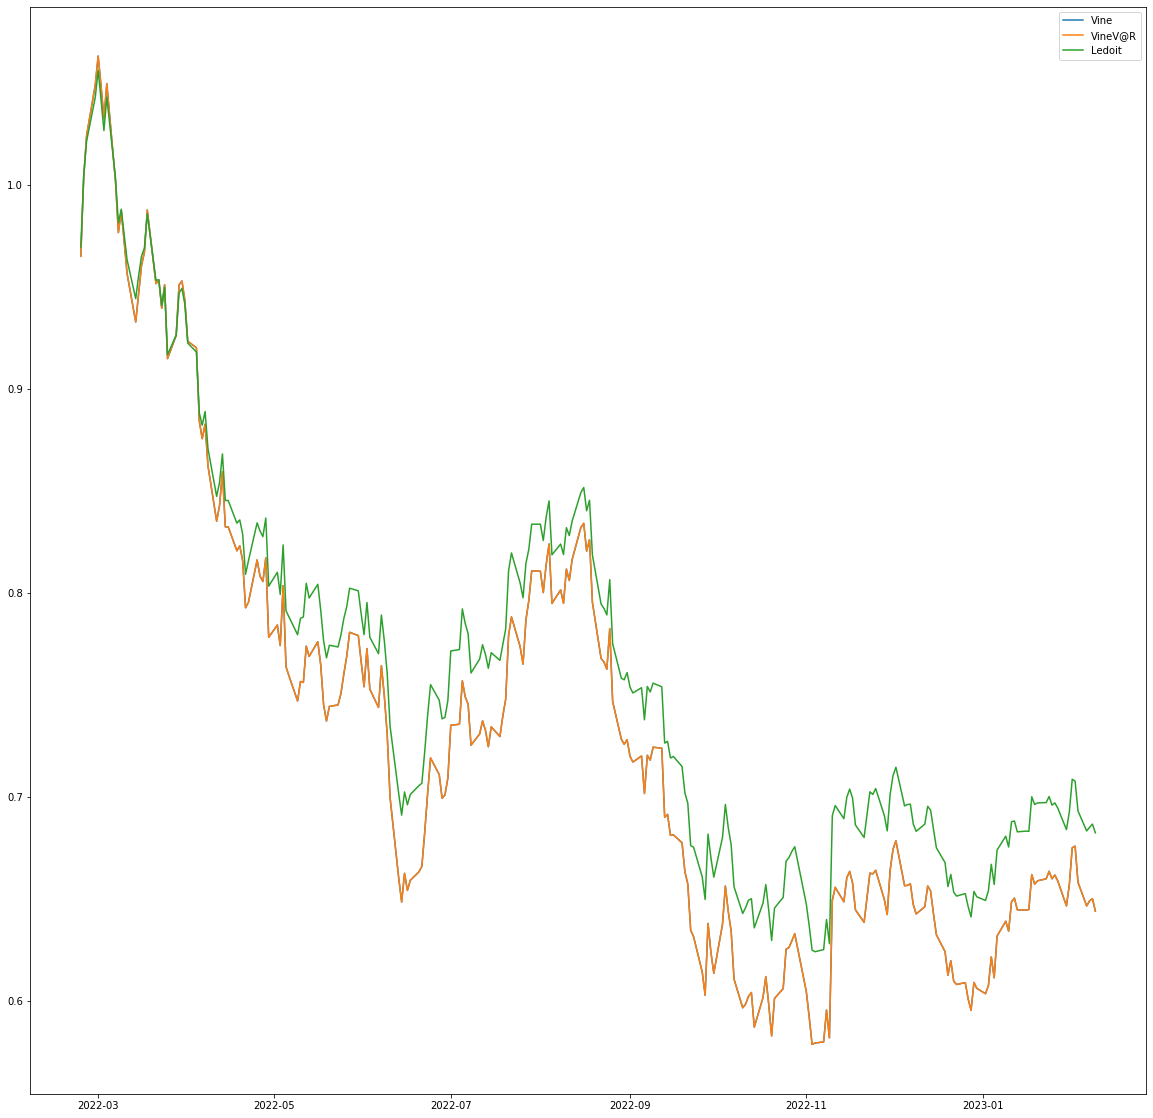

In [34]:
# Plotting Accumulated Returns
quotes_os = pd.DataFrame({"VineCopula": np.exp(np.sum(df_log_ret.iloc[-n_os:, :] * allocation_weights["VineCopula"] / returns_scale_factor, axis=1).cumsum()), "VineCopulaV@R": np.exp(np.sum(df_log_ret.iloc[-n_os:, :] * allocation_weights["VineCopulaV@R"] / returns_scale_factor, axis=1).cumsum()), "Ledoit": np.exp(np.sum(df_log_ret.iloc[-n_os:, :] * allocation_weights["LedoitWolf"] / returns_scale_factor, axis=1).cumsum())}, index=df_log_ret.iloc[-n_os:, :].index)

fig, ax = plt.subplots()
ax.plot(quotes_os.iloc[:, 0], label="Vine")
ax.plot(quotes_os.iloc[:, 1], label="VineV@R")
ax.plot(quotes_os.iloc[:, 2], label="Ledoit")
leg = ax.legend()
fig.set_size_inches(20, 20)

https://www.oreilly.com/library/view/bayesian-statistics-an/9781118359778/OEBPS/c1-sec1-0007.htm